In [64]:
import numpy as np
import pandas as pd
import pymystem3
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimkoltugin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Download data

In [77]:
train_df = pd.read_excel('Data/train_data_exam_1.xlsx')
test_df = pd.read_excel('Data/test_data_exam_1.xlsx')

# deleting nan and rows containing non-string value at 'original_data'
train_df = train_df.dropna()
train_df = train_df[pd.to_numeric(train_df['original_data'], errors='coerce').isna()].reset_index(drop=True)
test_df = test_df.dropna()
test_df = test_df[pd.to_numeric(test_df['original_data'], errors='coerce').isna()].reset_index(drop=True)

X_train, y_train = train_df['original_data'], train_df['score']
X_test, y_test = test_df['original_data'], test_df['score']

### Tokenize, lemmatize data

In [78]:
m = pymystem3.Mystem()


def lemmatize(X):
    data = []
    for s in tqdm(X):
        s = re.sub(r"[\\:,.?“/!@#$1234567890#—_ツ►๑۩۞۩•*”˜˜”*°°*`)(]", ' ', s)
        s = m.lemmatize(s)
        s = ''.join(s)
        data.append(s)
    return data


lem_X_train = lemmatize(X_train)
lem_X_test = lemmatize(X_test)

print(lem_X_train[12345])

100%|██████████| 8020/8020 [00:36<00:00, 220.15it/s]

главное-не терять разговорный русский  иначе быть порицать    с индус общаться вот где хард кор  английский вообще-то из европа    в скандинавия  великобритания неплохо он владеть    ваш ко  недавно находить свой читательский билет  английский библиотека  залогиниться  обнаруживать возможность скачивать неплохий аудиокнига  если говорить о современный российский  то они предпочитать робото зачитывание  а точно весь они в топка    а английский  довольно качественный  сейчас  приключение геккельберифин с нигер слушать      у вы и русский постепенно теряться  по крайний мера  письменный    например  в этот пост слово иностранный  офис  по-русски писаться без двойной  ф    я в переводчик на смартфон говорить по-русски  а он по-английски  в планшет наоборот настраивать  хотеть процент    попадание добиваться 



### Form the vocabulary of the most valuable words

In [79]:
words = stopwords.words("russian")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words=words, max_df=1., min_df=0.002)
tfidf_vectorizer.fit_transform(lem_X_train).toarray()
features = tfidf_vectorizer.get_feature_names_out()
vocabulary = {word: idx for idx, word in enumerate(features)}

print(features[1000:1050])
print(f'\nVocabulary size: {len(vocabulary)}')

['дешевый' 'деяние' 'деятель' 'деятельность' 'джихад' 'джон' 'диагноз'
 'диалог' 'дивизия' 'дизайн' 'дикарь' 'дикий' 'дико' 'диктатор'
 'диктатура' 'дима' 'димон' 'динамика' 'диплом' 'дипломат'
 'дипломатический' 'директор' 'диск' 'дискредитировать' 'дискриминация'
 'дискуссия' 'диссертация' 'диссидент' 'дистанция' 'дисциплина' 'длинный'
 'длительный' 'дмитрий' 'дневной' 'дно' 'добавка' 'добавлять'
 'добавляться' 'добивать' 'добиваться' 'добираться' 'добро' 'добровольно'
 'добровольный' 'добрый' 'добывать' 'добыча' 'доверие' 'доверять' 'довод']

Vocabulary size: 5411


### Display distribution of doc lenghtes:

100%|██████████| 18715/18715 [00:12<00:00, 1479.66it/s]


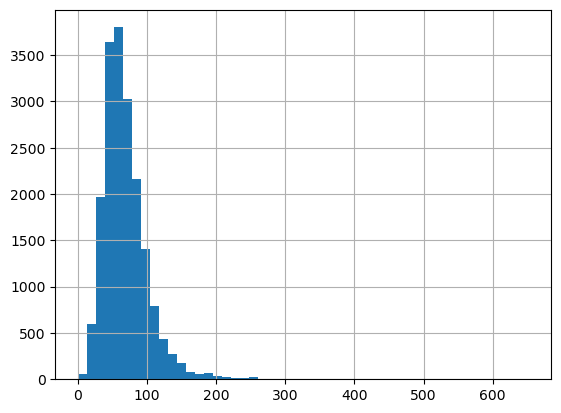

In [80]:
df_for_display = pd.DataFrame({'encoded_words_seq': []})

for doc_idx in tqdm(range(len(lem_X_train))):
    doc_words = []
    for word in lem_X_train[doc_idx].split(' '):
        if word in vocabulary:
            doc_words.append(vocabulary[word])
    df_for_display.loc[len(df_for_display.index)] = [doc_words]

df_for_display['length'] = df_for_display['encoded_words_seq'].str.len()
df_for_display['length'].hist(bins=50)
plt.show()

### Standartize doc length:

In [81]:
max_text_length = 100
padding_symbol = len(vocabulary)
print(f'padding_index: {padding_symbol}')


def standartize_doc_length(df: list):
    rnn_df = pd.DataFrame({'encoded_words_seq': []})

    for doc_idx in tqdm(range(len(df))):
        doc_words = []
        for word in df[doc_idx].split(' '):
            if word in vocabulary:
                doc_words.append(vocabulary[word])
        doc_words.extend([padding_symbol] * (max_text_length - len(doc_words)))
        rnn_df.loc[len(rnn_df.index)] = [doc_words[:max_text_length]]
    return rnn_df


X_train = standartize_doc_length(lem_X_train)
X_test = standartize_doc_length(lem_X_test)
print(X_train.head())

padding_index: 5411


100%|██████████| 8020/8020 [00:04<00:00, 1922.48it/s]

                                   encoded_words_seq
0  [6, 8, 4, 2396, 4000, 3771, 365, 3999, 1297, 5...
1  [2225, 1822, 4372, 3397, 4597, 1386, 4562, 464...
2  [4806, 197, 619, 817, 4554, 3659, 582, 4313, 3...
3  [2875, 1101, 1790, 422, 2152, 1078, 3608, 2029...
4  [1858, 4009, 3885, 4601, 5068, 4672, 4782, 370...


### Downsample/upsample, so that each label is present in the amount of $n$ observations

In [90]:
train_df = pd.concat([X_train, y_train], axis=1)

print(f"before balancing:\n{train_df['score'].value_counts()}")

strong_negative = train_df[train_df['score'] == -2]
negative = train_df[train_df['score'] == -1]
neutral = train_df[train_df['score'] == 0]
positive = train_df[train_df['score'] == 1]
strong_positive = train_df[train_df['score'] == 2]

n = neutral.shape[0]

params = {'replace': True, 'n_samples': n, 'random_state': 0}

strong_negative = resample(strong_negative, **params)
negative = resample(negative, **params)
neutral = resample(neutral, **params)
positive = resample(positive, **params)
strong_positive = resample(strong_positive, **params)

train_df = pd.concat([strong_negative, negative, neutral, positive, strong_positive])
X_train, y_train = train_df['encoded_words_seq'], train_df['score']

print(f"\nafter balancing:\n{train_df['score'].value_counts()}")

before balancing:
 0    9737
-1    6465
 1    1204
-2    1059
 2     250
Name: score, dtype: int64

after balancing:
-2    9737
-1    9737
 0    9737
 1    9737
 2    9737
Name: score, dtype: int64


In [92]:
X_train = pd.DataFrame(X_train.tolist()).to_numpy().astype(int)
X_test = pd.DataFrame(X_test['encoded_words_seq'].tolist()).to_numpy().astype(int)
print(X_train.shape)
print(X_test.shape)

(48685, 100)
(8020, 100)


In [93]:
# saving only Xs because ys are common with non-rnn df
np.save('Data/rnn_X_train', X_train)
np.save('Data/rnn_X_test', X_test)